In [29]:
import numpy as np
import pandas as pd
import uproot
from scipy.stats import poisson
from scipy.special import factorial
from scipy.stats import norm
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import time

## Prepare Data

In [2]:
# input folder
filepath_prefix = "samples/ntuples-VBF-ANA-mc1516-"

# collect data of each process
processes = ['ggF', 'VBF', 'top', 'WW', 'Zjets']
columns = ['weight', 'event_number', 'MT', 'Mll', 'Mjj', 'N_bjets', 'm_tautau', 'mZ', 'OLV', 'centralJetVetoLeadpT', 'lep0_flavour', 'lep1_flavour', 'dilepton_charge']

mcData = []
for i in range(len(processes)):
    file = uproot.open(filepath_prefix + processes[i] + ".root")
    df = file['observables'].arrays(columns, library="pd")
    df['process'] = [processes[i] for evt in range(len(df))] # add a column to label each event
    mcData.append(df)

mcData = pd.concat(mcData, ignore_index=True)

In [5]:
file = uproot.open("samples/ntuple-VBF-ANA-data1516.root")
realData = file['observables'].arrays(columns, library="pd")
realData['process'] = ['data' for evt in range(len(realData))] #actual data from detector?

In [6]:
def SR_selections(dataset): #define a function to apply signal region cuts to dataset
    
    dataset_VBFSR = dataset[(dataset['N_bjets']==0) 
                          & (dataset['m_tautau'] < dataset['mZ']-25) 
                          & (dataset['centralJetVetoLeadpT']/1000. < 30) 
                          & (dataset['OLV'] == 1.) 
                          & (dataset['Mjj'] > 120.)]
    return dataset_VBFSR

In [7]:
mc_VBFSR = SR_selections(mcData)
realdata_VBFSR = SR_selections(realData)

## Goal: Claim the discovery of the Higgs boson from VBF production in HWW decay

### How to do that? $\to$ Calculate the significance

#### Exercise 1: understand p-value and significance

Let's consider a simple case: From the previous task, you can see in the signal region there are 2961 (56 signal + 2905 background) events. 

Assume the number of particles follow the Poisson distribution, then we can construct the probability distribution if there's no Higgs (background-only hypothesis).

$$\text{Poisson} = \frac{b^n}{n!}e^{-b}$$

In [24]:
"""
n = total number of events
s = expected number of signal
b = expected number of background
"""

n_obs = len(realdata_VBFSR)
n_mc = round(np.sum(mc_VBFSR['weight']))
#sum all event weight from every MC samples (after SR cut)
s = round(np.sum(mc_VBFSR[mc_VBFSR['process']=='VBF']['weight']))
#sum all event weight from every VBF sample (after SR cut)
b = round(np.sum(mc_VBFSR['weight']) - s)
#sum of all event weight, excluding VBF sample with SR cut applied
print("n_obs: {}, n_mc: {}, s: {}, b: {}".format(n_obs, n_mc, s, b))

fig, ax = plt.subplots(1,1, figsize=(8,8))
bin_size = np.arange(2700, 3100)

# poisson.pmf(n, b) b is the mean value, n is the range in which the distribution is plotted 
plt.plot(bin_size, poisson.pmf(bin_size, b), color = "blue", linestyle="-",linewidth=1,label="Background only")
#recall b is the expected amount of background events
plt.scatter(n_obs, poisson.pmf(n_obs, b), s=150, label='Real data')
#amount of background events in real data: n_obs
plt.scatter(n_mc, poisson.pmf(n_mc, b), s=150, label='MC data')
#amount of background events in MC samples
plt.title("Prob. of background-only model vs. Data point", fontsize=18)
plt.legend(loc="upper right", prop={'size':12})
plt.show()

n_obs: 3051, n_mc: 2961, s: 56, b: 2905


### p-value

: Probability to observe an event that is equal to or higher than the current one.

### Significance (Z)
: Describe the p-value by standard deviation form. Typically, we will claim a discovery if $Z \geq 5 \sigma$ (corresponding to p-value = 2.87 $\times 10^{-7}$ ).

$$ \text{p-value} = \int_Z^{\infty} \text{Gaussian }(x,\mu=0, \sigma=1) dx$$
$$f(x) = \frac{1}{\sigma \sqrt{2 \pi}}\exp\left[-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right]$$

* Here's a quick formula to estimate the significance:
$$ Z \approx \frac{s}{\sqrt{b}}$$

In [31]:
def normal(x,sigma,mu):
    a = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*(((x-mu)/sigma)**2))
    return a
integrate.quad(lambda x: normal(x,1,0),5,np.inf)

(2.8665157035203983e-07, 8.853463755027523e-10)

In [32]:
"""
Calculate the p-value & significance
"""

# observed
#cumulative density function: from 0 to n_obs
#tail probability = 1-cdf(n_obs,b) (probability from n_obs to inf)
#equivalent: sf (survival function) poisson.sf(n_obs,b)
p_value_obs = 1 - poisson.cdf(n_obs,b)
print('p_value_obs: ', p_value_obs)

#ppf(q,mu) inverse of cdf
#cdf: random variable -> cumulated probability
#ppf: cumulated probability -> random variable
Z_obs = norm.ppf(1-p_value_obs) # 1-(1-poisson.cdf(n_obs,b))
print("significance (obs): ", Z_obs)


print("")
# mc
p_value_mc = 1 - poisson.cdf(n_mc,b)
print('p_value_mc: ', p_value_mc)

Z_mc = norm.ppf(1-p_value_mc)
print("significance (mc): ", Z_mc)




print("")
print("approx. Z_obs: ", s/np.sqrt(b))

p_value_obs:  0.0034796787629414183
significance (obs):  2.69878282533322

p_value_mc:  0.1473222921329682
significance (mc):  1.0479870263600746

approx. Z_obs:  1.0389985910910353


### Significance not very good... Any ways to improve it?

* Collect more data
* Split the SR into more bins
    * Use a more powerful discriminant (e.g. DNN)

Increased Z
>$\uparrow$ Increased poisson.cdf(n,b)
> >$\uparrow$ Decreased p-value
> > >$\uparrow$ left shift of distribution function
> > > >$\uparrow$ decrease of b
> > > > >$\uparrow$ decreased expected amount of background events

signal + background event amount is fixed $\rightarrow$ increase signal/background ratio to increase significance

Increased Z
>$\uparrow$ Increased poisson.cdf(n,b)
> >$\uparrow$ Decreased p-value
> > >$\uparrow$ cumulated probability from 0 to n increased
> > > >$\uparrow$ increase of n
> > > > >$\uparrow$ increase amount of total events

Increase total amount of events (n) while expected value is *unchanged or increased by a smaller amount* $\rightarrow$ signal/background ratio increase.

#### 1. Collect more data

In [59]:
"""
Calculate the p-value & significance with more events
"""

larger_s = 4*s
larger_b = 4*b
larger_n_mc = 4*n_mc

p_value = 1 - poisson.cdf(larger_n_mc,larger_b)
print('p_value_mc: ', p_value)

Z = norm.ppf(1-p_value)
print("significance (mc): ", Z)

print("")
print("approx. Z_mc: ", larger_s/np.sqrt(larger_b))

p_value_mc:  0.018876608641691273
significance (mc):  2.077524056515523

approx. Z_mc:  2.0779971821820706


In [64]:
"""
n = total number of events
s = expected number of signal
b = expected number of background
"""
fig, ax = plt.subplots(1,1, figsize=(8,8))
bin_size = np.arange(2500,3500)
larger_bin_size = np.arange(11300, 12300)
plt.plot(bin_size, poisson.pmf(bin_size, b), color = "C1", linestyle="-",linewidth=1,label="Background only")
plt.scatter(n_mc, poisson.pmf(n_mc, b), s=150, color = "C0", label='MC data')
#original poisson distribution
plt.plot(bin_size, poisson.pmf(bin_size, 0.99*b), color = "C2", linestyle="-",linewidth=1,label="Increased S/B ratio")
plt.scatter(n_mc, poisson.pmf(n_mc, 0.99*b), s=150, color = "C0")
#poisson distribution with decreased mean value (total event count same, more signal, less background events, increased S/B ratio)

plt.axvline(n_mc,color="C3",linestyle='--')
plt.title("Prob. of background-only model vs. Data point", fontsize=18)
plt.legend(loc="upper left", prop={'size':12})

fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(larger_bin_size, poisson.pmf(larger_bin_size, larger_b), color = "C2" , linestyle="-",linewidth=1,label="Upscaled Background")
plt.scatter(larger_n_mc, poisson.pmf(larger_n_mc, larger_b), s=150, label='MC data (Upscaled)')
#scaled poisson distribution (scaled total event count, more signal, more background events, same ratio)
plt.title("Prob. of background-only model vs. Data point", fontsize=18)
plt.legend(loc="upper right", prop={'size':12})

#### 2. Split the SR into more bins

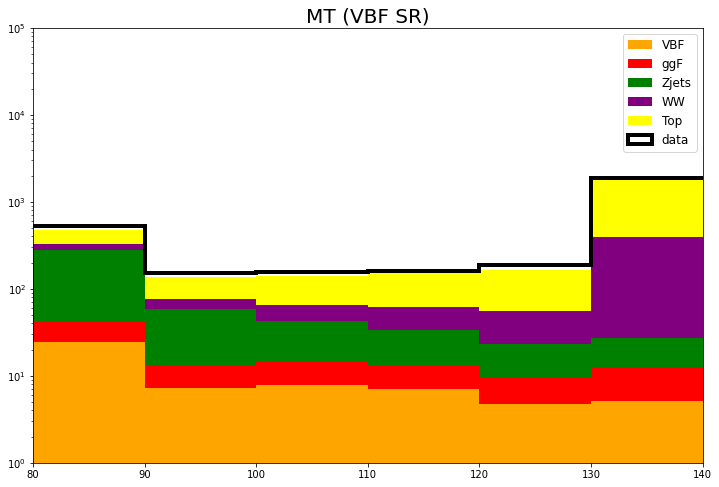

In [57]:
"""
mc_VBFSR = SR_selections(mcData)
realdata_VBFSR = SR_selections(realData)
"""
mcggF_VBFSR = mc_VBFSR[mc_VBFSR['process']=='ggF']
mcVBF_VBFSR = mc_VBFSR[mc_VBFSR['process']=='VBF']
mctop_VBFSR = mc_VBFSR[mc_VBFSR['process']=='top']
mcWW_VBFSR = mc_VBFSR[mc_VBFSR['process']=='WW']
mcZjets_VBFSR = mc_VBFSR[mc_VBFSR['process']=='Zjets']

# MT distribution in VBF SR (with an optimized binning)
optimized_binning = [0, 90, 100, 110, 120, 130, np.max(mc_VBFSR['MT'])]

fig, ax = plt.subplots(1,1,figsize=(12,8))
color = ["orange", "red", "green", "purple", "yellow"]
# plot the stacked plots
plt.hist([mcVBF_VBFSR['MT'], mcggF_VBFSR['MT'], mcZjets_VBFSR['MT'], mcWW_VBFSR['MT'], mctop_VBFSR['MT']], 
         bins=optimized_binning, 
         stacked=True, 
         color=color, 
         linewidth = 2, 
         density=False, 
         weights=[mcVBF_VBFSR['weight'], mcggF_VBFSR['weight'], mcZjets_VBFSR['weight'], mcWW_VBFSR['weight'], mctop_VBFSR['weight']], 
         label=['VBF', 'ggF', 'Zjets', 'WW', 'Top'])

plt.hist(realdata_VBFSR['MT'], bins=optimized_binning, histtype='step', linewidth=4, color='black', density=False, label='data')

plt.legend(loc="upper right", prop={'size':12})
plt.xlim(80, 140)
plt.yscale('log')
plt.ylim((1,10**5))
plt.title('MT (VBF SR)', fontsize=20)

plt.show()

In [58]:
"""
Calculate the significance bin-by-bin, and add in quadrature.
mc_VBFSR = SR_selections(mcData)
mcVBF_VBFSR = mc_VBFSR[mc_VBFSR['process']=='VBF']
"""

mcbkg_VBFSR = mc_VBFSR[mc_VBFSR['process']!='VBF']

# get number of signal and background events in each MT bin
hist_sig, _ = np.histogram(mcVBF_VBFSR['MT'], bins=optimized_binning, weights=mcVBF_VBFSR['weight'])
hist_bkg, _ = np.histogram(mcbkg_VBFSR['MT'], bins=optimized_binning, weights=mcbkg_VBFSR['weight'])
#numpy.histogram([array],[bins]) returns: ([count in each bin],[bins]) [bins] output is passed to '_' 

def calculate_significance(s,b):
    
    n = s + b
    p_value = 1 - poisson.cdf(n,b)
    Z = norm.ppf(1-p_value)
    
    return Z


# add the significance per bin in quadrature

significance_square = 0
for (sig, bkg) in zip(hist_sig, hist_bkg):
    significance_square += calculate_significance(sig, bkg)**2
    
total_significance = np.sqrt(significance_square)
print("total_significance: ", total_significance)

total_significance:  1.6494392288596165


## More in real analyses

The above exercise is just a simple way to get the significance. In real world, we also have to measure:

1. signal strength: $N_{signal}$(obs)/ $N_{signal}$(expected)

2. nuisance parameter:

    a. normalization factor: $N_{bkg\_in\_CR}$(obs)/ $N_{bkg\_in\_CR}$(expected)
    
    b. effects by lots of theoretical and experimental uncertainties
    
$\to$ This is called "parameter estimation".

## How to do parameter estimation? $\to$ Likelihood fit

### *Reading assignment*
textbook: https://drive.google.com/file/d/19cq9hfyTWXqM9MKLb-L6GjFakJFa9tWX/view?usp=sharing

1. Introduction to parameter estimation: Chapter 5.1 - 5.5

2. Introduction to likelihood function: Chapter 5.10.1